In [1]:
%load_ext autoreload
%load_ext tensorboard
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import os
import random
import yaml
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from matplotlib import cm
import seaborn as sns
from importlib import reload
from pathlib import Path
import sklearn
import joblib
import torch
import pandas as pd
import copy

# Set the font to a nicer font
rc('text', usetex=True)
plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "serif"

In [3]:
import scipy.stats as stats

def check_significance(model1_accuracies, model2_accuracies, alpha=0.05, paired=True):
    """
    Checks if the difference in accuracies between two models is statistically significant.

    Args:
        model1_accuracies (list): Accuracies for Model 1 across runs.
        model2_accuracies (list): Accuracies for Model 2 across runs.
        alpha (float): Significance level (default is 0.05).
        paired (bool): Whether to use a paired t-test (default is True). If False, uses an independent t-test.

    Returns:
        bool: True if the difference is statistically significant, False otherwise.
    """
    min_len = min(len(model1_accuracies), len(model2_accuracies))
    if paired:
        # Paired t-test for dependent samples
        _, p_value = stats.ttest_rel(model1_accuracies[:min_len], model2_accuracies[:min_len])
    else:
        # Independent t-test for independent samples
        _, p_value = stats.ttest_ind(model1_accuracies[:min_len], model2_accuracies[:min_len])

    return p_value < alpha

def get_metric_from_dict(results, method, metric):
    vals = []
    for _, metric_keys in results.items():
        for candidate_method, metric_map in metric_keys.items():
            if method != candidate_method:
                continue
            for metric_name, val in metric_map.items():
                if metric_name == metric:
                    vals.append(val)
    return vals


# Color and Marker Definitions

In [4]:
# Plot Hyperparameters
clrs = sns.color_palette("deep", 15)
MAIN_METHOD = "MixCEM Final All Sample"

color_map = {
    "Bayes MLP": "black",
    "Bayes Classifier": "black",
    "MixCEM (ours)": "red",
    "MixCEM (Platt Calibrated)": "red",
    "MixCEM (No Calibration)": "gray",
    "MixCEM (no IntCEM loss)": "black",
    "MixCEM + IntCEM": "orange",
    "MixIntCEM (ours)": "orange",
    "IntCEM": "cyan",
    "Logit Joint CBM": "salmon",
    "Independent CBM": "lightgreen",
    "Sequential CBM": "slateblue",
    "CEM + Oracle OOD Detector": "pink",
}

baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    # "Sigmoidal CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "Entropy CMCMixCEM",
    "Bayes MLP",
    "Sequential CBM",
    "Independent CBM",
    "Logit Joint CBM",
]
for idx, baseline in enumerate(baselines_to_include):
    if baseline not in color_map:
        color_map[baseline] = clrs[idx]

markers = {
    "Joint CBM": '-o',
    "Vanilla CBM": '-o',
    "Sigmoidal Joint CBM": '-o',
    "Logit Joint CBM": '-v',
    "Sequential CBM": '-^',
    "Independent CBM": '-2',
    "Hybrid-CBM": '-v',
    "Hybrid CBM": '-v',
    "CEM": '-^',
    "IntCEM": '-x',
    "ProbCBM": '-s',
    "Posthoc CBM": '-p',
    "P-CBM": '-p',
    "Posthoc Hybrid CBM": '-1',
    "Hybrid Posthoc CBM": '-1',
    "Hybrid P-CBM": '-1',
    "MixCEM (ours)": '--*',
    "MixCEM (Platt Calibrated)": '--*',
    "MixCEM (No Calibration)": ':*',
    "MixCEM (no IntCEM loss)": ":*",
    "MixCEM + IntCEM": ":*",
    "MixIntCEM (ours)": ":*",
    "Bayes MLP": ":.",
    "Bayes Classifier": ":.",
    "CEM + Oracle OOD Detector": ":.",
}

max_limit = 10

select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'

rename_map = {
    "Entropy CMCMixIntCEM": "MixIntCEM (ours)",
    "Entropy CMCMixCEM": "MixCEM (ours)",
    MAIN_METHOD: "MixCEM (ours)",
    MAIN_METHOD + " No Calibration": "MixCEM (No Calibration)",
    "MixCEM Final All No Sample": "MixCEM (No test-time sampling)",
    "MixCEM Final Sample No Calibration": "MixCEM (No Calibration)",
    "MixCEM Final Sample": "MixCEM (Platt Calibrated)",
    "MixCEM Final": "MixCEM (ours)",
    "MixCEM Final All": "MixCEM (ours)",
    "Entropy CMCMixIntCEM No Calibration": "MixIntCEM (No Calibration)",
    "Entropy CMCMixCEM No Calibration": "MixCEM (No Calibration)",
    "MixCEM Final No Calibration": "MixCEM (No Calibration)",
    "Posthoc Hybrid CBM": "Residual P-CBM",
    "Hybrid Posthoc CBM": "Residual P-CBM",
    "Posthoc CBM": "P-CBM",
    "Bayes MLP": "Bayes Classifier",
    "Joint CBM": "Vanilla CBM",
    "Hybrid-CBM": "Hybrid CBM",
    "FixedOnlyGTCEM": "CEM + Oracle OOD Detector",
}
used_rename_map = rename_map
show_variance = True
ood_suffix = 'OOD_sap_0.1_'

# CEM + OOD Detector Plots

In [9]:
from texttable import Texttable
import latextable
from collections import defaultdict

results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_complete/',
        name='CUB',
        n_concepts=112,
        n_groups=28,
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='CUB-Incomplete',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
        n_concepts=22,
        n_groups=7,
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_complete/',
        name='AwA2',
        n_concepts=85,
        n_groups=28,
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_incomplete/',
        name='AwA2-Incomplete',
        n_concepts=9,
        n_groups=6,
    ),
    # dict(
    #     path='/anfs/bigdisc/me466/mixcem_results/cifar10/',
    #     name='CIFAR10',
    #     n_concepts=143,
    #     n_groups=143,
    #     intervention_freq=11,
    # ),
    # dict(
    #     path='/anfs/bigdisc/me466/mixcem_results/celeba/',
    #     name='CelebA',
    #     n_concepts=9,
    #     n_groups=6,
    # ),
    # dict(
    #     path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_complete/',
    #     name='TravelingBirds',
    #     n_concepts=112,
    #     n_groups=28,
    # ),
    # dict(
    #     path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_incomplete/',
    #     name='TravelingBirds-Incomplete',
    #     n_concepts=22,
    #     n_groups=7,
    # ),
]
select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))
    res['selected_models'] = joblib.load(os.path.join(res['path'], f'selected_models_{select_metric}.joblib'))

baselines_to_include = [
    "DNN",
    "Joint CBM",
    "Hybrid-CBM",
    "Sigmoidal CEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "CEM",
    "IntCEM",
    "FixedOnlyGTCEM",
    MAIN_METHOD,
]
for dataset_results in results_to_include:
    print("****" * 10, f"{dataset_results['name']}", "****" * 10)
    for label in baselines_to_include:
        real_label = dataset_results.get('rename', {}).get(label, label)
        used_select_metric = dataset_results.get(
            'select_metric',
            select_metric,
        )
        model_name = dataset_results['selected_models'].get(
            real_label + " (Baseline)",
            real_label + " (Baseline)",
        )
        print(f"\tFor {label} we selected:", model_name)

**************************************** CUB ****************************************
	For DNN we selected: DNN_extra_dims_200
	For Joint CBM we selected: CBM_Sigmoid_Baseline_cwl_10
	For Hybrid-CBM we selected: Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5
	For Sigmoidal CEM we selected: Sigmoidal CEM (Baseline)
	For ProbCBM we selected: ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	For Posthoc CBM we selected: PCBM_reg_1e-06_l1_0.99_penalty_1
	For Posthoc Hybrid CBM we selected: HybridPCBM_reg_1e-06_l1_0.99_penalty_1
	For CEM we selected: CEM_Baseline_cwl_1
	For IntCEM we selected: IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_1
	For FixedOnlyGTCEM we selected: FixedOnlyGTCEM_cwl_1
	For MixCEM Final All Sample we selected: MixCEM_Final_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.5_emb_16_True_tip_0.25_itd_1_iw_0_cwl_1
****************************************

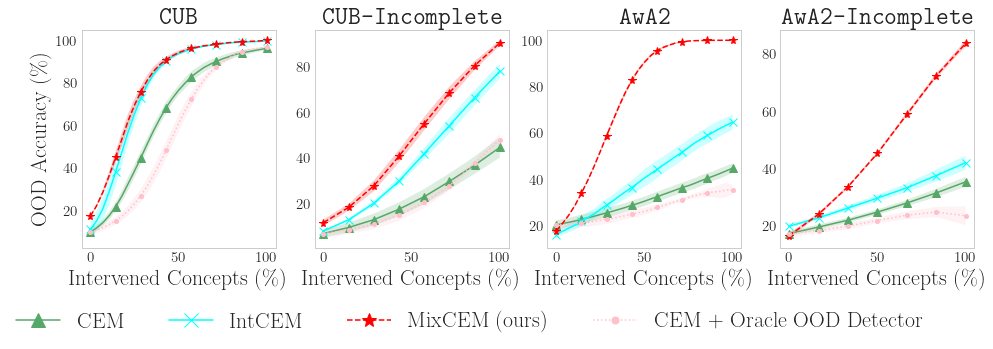

In [6]:
used_results_to_include = [
    x for x in results_to_include
    if "TravelingBirds" not in x['name']
]

used_baselines_to_include = [
    # "Joint CBM",
    # "Hybrid-CBM",
    "CEM",
    "IntCEM",
    # "ProbCBM",
    # "Posthoc CBM",
    # "Posthoc Hybrid CBM",
    MAIN_METHOD,
    "FixedOnlyGTCEM",
    # "Bayes MLP",
]
std_scale = 1

fig, axs = plt.subplots(1, len(used_results_to_include), figsize=(4*len(used_results_to_include), 4), squeeze=False)
for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        # ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(used_baselines_to_include):
            label = dataset_results.get('rename', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = rename_map.get(label, label)
            if ("Bayes" in label) and ("OOD" not in mode_name):
                continue
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = dataset_results['n_concepts']
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
                )
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=8,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=8,
                )
            else:
                # Otherwise, plot all points
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=8,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - std_scale * stds,
                    means + std_scale * stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(-5, 105)
        if col == 0:
            if row == 0:
                ax.set_ylabel("OOD Accuracy (\%)", fontsize=22)
            else:
                ax.set_ylabel("ID Accuracy (\%)", fontsize=22)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts (\%)", fontsize=22)
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)
        ax.grid(False)
        if row == 0:
            ax.set_title(r'\texttt{' + dataset_results['name'] + '}', fontsize=25)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=22,
    loc='upper center',
    bbox_to_anchor=(-1.6,-0.2),
    ncol=4,
    markerscale=1.75,
)
plt.savefig(f"../figures/paper/rebuttal_cem_with_ood_detector{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/paper/rebuttal_cem_with_ood_detector{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.savefig(f"../figures/rebuttal_cem_with_ood_detector{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/rebuttal_cem_with_ood_detector{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

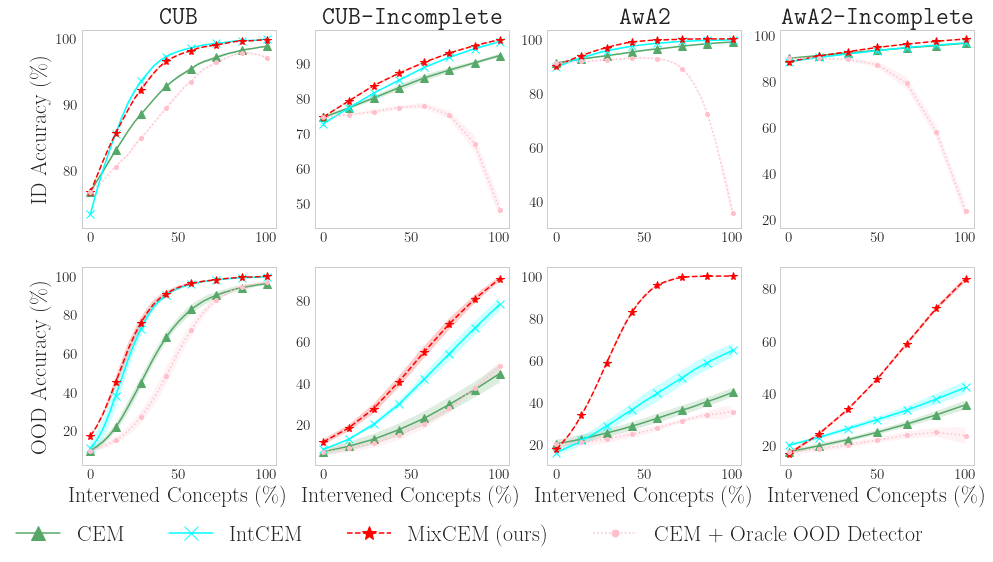

In [10]:
used_results_to_include = [
    x for x in results_to_include
    if "TravelingBirds" not in x['name']
]

used_baselines_to_include = [
    # "Joint CBM",
    # "Hybrid-CBM",
    "CEM",
    "IntCEM",
    # "ProbCBM",
    # "Posthoc CBM",
    # "Posthoc Hybrid CBM",
    MAIN_METHOD,
    "FixedOnlyGTCEM",
    # "Bayes MLP",
]
std_scale = 1

fig, axs = plt.subplots(2, len(used_results_to_include), figsize=(4*len(used_results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(used_baselines_to_include):
            label = dataset_results.get('rename', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = rename_map.get(label, label)
            if ("Bayes" in label) and ("OOD" not in mode_name):
                continue
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = dataset_results['n_concepts']
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
                )
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=8,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=8,
                )
            else:
                # Otherwise, plot all points
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=8,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - std_scale * stds,
                    means + std_scale * stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(-5, 105)
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (\%)", fontsize=22)
            else:
                ax.set_ylabel("OOD Accuracy (\%)", fontsize=22)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts (\%)", fontsize=22)
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)
        ax.grid(False)
        if row == 0:
            ax.set_title(r'\texttt{' + dataset_results['name'] + '}', fontsize=25)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=22,
    loc='upper center',
    bbox_to_anchor=(-1.6,-0.2),
    ncol=4,
    markerscale=1.75,
)
plt.savefig(f"../figures/paper/rebuttal_cem_with_ood_detector_complete{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/paper/rebuttal_cem_with_ood_detector_complete{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.savefig(f"../figures/rebuttal_cem_with_ood_detector_complete{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/rebuttal_cem_with_ood_detector_complete{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

# Other Forms of Noise Experiments

In [5]:
from texttable import Texttable
import latextable
from collections import defaultdict

results_to_include = [
    # dict(
    #     path='/anfs/bigdisc/me466/mixcem_results/cub_complete/',
    #     name='CUB',
    #     n_concepts=112,
    #     n_groups=28,
    # ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete_rebuttal_noise/',
        name='CUB-Incomplete',
        # rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
        n_concepts=22,
        n_groups=7,
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_complete_rebuttal_noise/',
        name='AwA2',
        n_concepts=85,
        n_groups=28,
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_incomplete_rebuttal_noise/',
        name='AwA2-Incomplete',
        n_concepts=9,
        n_groups=6,
    ),
]
select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))
    res['selected_models'] = joblib.load(os.path.join(res['path'], f'selected_models_{select_metric}.joblib'))

baselines_to_include = [
    "DNN",
    "Joint CBM",
    "Hybrid-CBM",
    "Sigmoidal CEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "CEM",
    "IntCEM",
    "FixedOnlyGTCEM",
    MAIN_METHOD,
]
for dataset_results in results_to_include:
    print("****" * 10, f"{dataset_results['name']}", "****" * 10)
    for label in baselines_to_include:
        real_label = dataset_results.get('rename', {}).get(label, label)
        used_select_metric = dataset_results.get(
            'select_metric',
            select_metric,
        )
        model_name = dataset_results['selected_models'].get(
            real_label + " (Baseline)",
            real_label + " (Baseline)",
        )
        print(f"\tFor {label} we selected:", model_name)

**************************************** CUB-Incomplete ****************************************
	For DNN we selected: DNN_extra_dims_200
	For Joint CBM we selected: CBM_Sigmoid_Baseline_cwl_1
	For Hybrid-CBM we selected: Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_1
	For Sigmoidal CEM we selected: Sigmoidal CEM (Baseline)
	For ProbCBM we selected: ProbCBM_cwl_class_hidden_dim_64_hidden_dim_16_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	For Posthoc CBM we selected: PCBM_reg_0.001_l1_0.99_penalty_1
	For Posthoc Hybrid CBM we selected: HybridPCBM_reg_0.1_l1_0.99_penalty_1
	For CEM we selected: CEM_Baseline_cwl_1
	For IntCEM we selected: IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.1_Baseline_cwl_1
	For FixedOnlyGTCEM we selected: FixedOnlyGTCEM (Baseline)
	For MixCEM Final All Sample we selected: MixCEM_Final_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1_iw_0_cwl_1
****************************

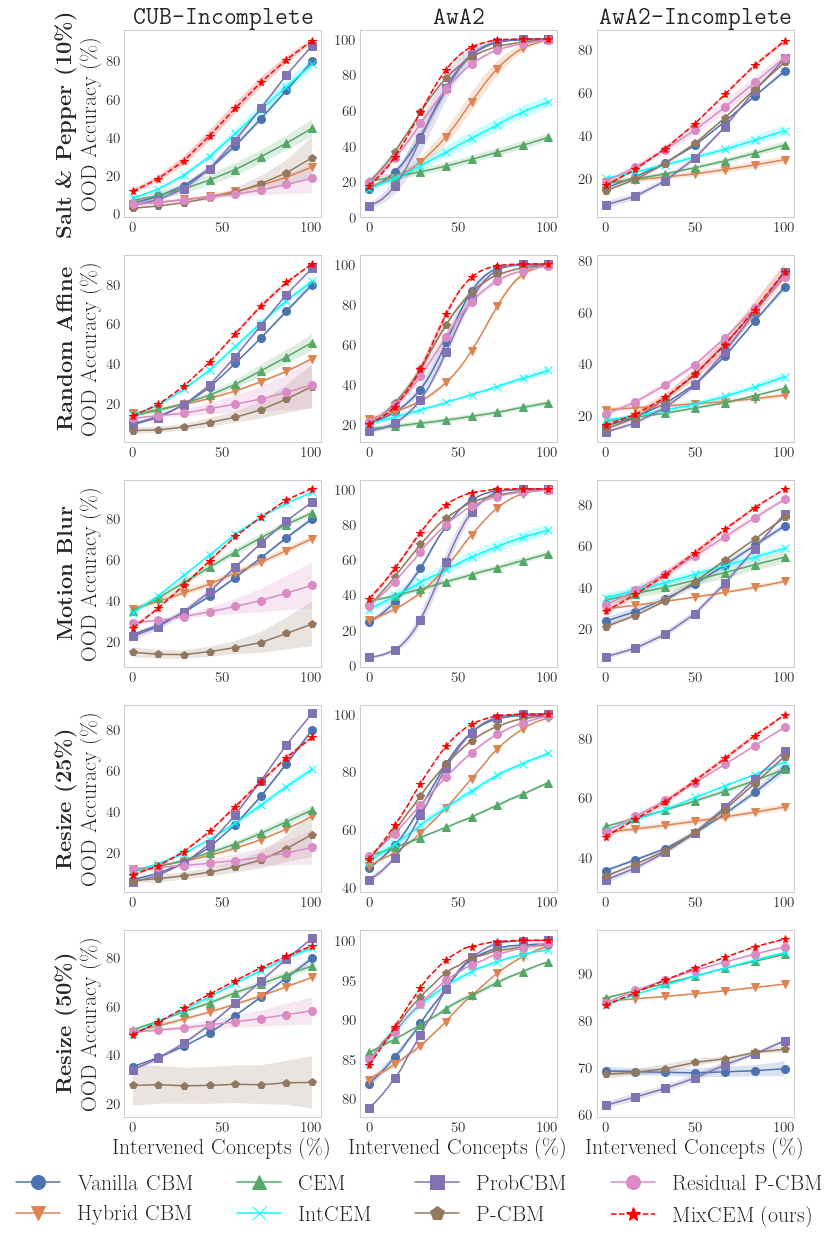

In [8]:
used_results_to_include = [
    x for x in results_to_include
    if "TravelingBirds" not in x['name']
]

used_baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    MAIN_METHOD,
    # "FixedOnlyGTCEM",
    # "Bayes MLP",
]
std_scale = 1
ood_suffixes = [
    ("OOD_sap_0.1_", "Salt \& Pepper (10\%)"),
    ("OOD_rand_affine_", "Random Affine"),
    ("OOD_gaussian_blur_5_", "Motion Blur"),
    ("OOD_resize_25_", "Resize (25\%)"),
    ("OOD_resize_50_", "Resize (50\%)"),
    # ("OOD_gaussian_1_", "Gaussian Noise"),
]

fig, axs = plt.subplots(len(ood_suffixes), len(used_results_to_include), figsize=(4*len(used_results_to_include), 4*len(ood_suffixes)), squeeze=False)
for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    selected_models = dataset_results['selected_models']
    (mode_name, mode_key) = ("Baseline OOD", " (Baseline)")
    for row, (ood_suffix, odd_name) in enumerate(ood_suffixes):
        ax = axs[row, col]
        for idx, label in enumerate(used_baselines_to_include):
            label = dataset_results.get('rename', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = rename_map.get(label, label)
            if ("Bayes" in label) and ("OOD" not in mode_name):
                continue
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = dataset_results['n_concepts']
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
                )
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=8,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=8,
                )
            else:
                # Otherwise, plot all points
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=8,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - std_scale * stds,
                    means + std_scale * stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(-5, 105)
        if col == 0:
            ax.set_ylabel(r"\textbf{" + f"{odd_name}" + "}\nOOD Accuracy (\%)", fontsize=22)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts (\%)", fontsize=22)
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)
        ax.grid(False)
        if row == 0:
            ax.set_title(r'\texttt{' + dataset_results['name'] + '}', fontsize=25)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=22,
    loc='upper center',
    bbox_to_anchor=(-0.9,-0.2),
    ncol=4,
    markerscale=1.75,
)
plt.savefig(f"../figures/paper/rebuttal_other_forms_of_noise{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/paper/rebuttal_other_forms_of_noise{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.savefig(f"../figures/rebuttal_other_forms_of_noise{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/rebuttal_other_forms_of_noise{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

# MNIST and SVHN Experiments

In [9]:
from texttable import Texttable
import latextable
from collections import defaultdict

results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/color_mnist_svhn_incomplete_40_rebuttal/',
        name='Digit Addition',
        n_concepts=40,
        n_groups=4,
    ),
]
select_metric = 'val_auc_y_random_group_level_True_use_prior_False_int_auc'
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))
    res['selected_models'] = joblib.load(os.path.join(res['path'], f'selected_models_{select_metric}.joblib'))

baselines_to_include = [
    "DNN",
    "Joint CBM",
    "Hybrid-CBM",
    "Sigmoidal CEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "CEM",
    "IntCEM",
    MAIN_METHOD,
]
for dataset_results in results_to_include:
    print("****" * 10, f"{dataset_results['name']}", "****" * 10)
    for label in baselines_to_include:
        real_label = dataset_results.get('rename', {}).get(label, label)
        used_select_metric = dataset_results.get(
            'select_metric',
            select_metric,
        )
        model_name = dataset_results['selected_models'].get(
            real_label + " (Baseline)",
            real_label + " (Baseline)",
        )
        print(f"\tFor {label} we selected:", model_name)

**************************************** Digit Addition ****************************************
	For DNN we selected: DNN_extra_dims_200
	For Joint CBM we selected: CBM_Sigmoid_cwl_1
	For Hybrid-CBM we selected: Hybrid-CBM_Sigmoid_extra_dims_50_cwl_1
	For Sigmoidal CEM we selected: Sigmoidal CEM (Baseline)
	For ProbCBM we selected: ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_150_max_task_epochs_150
	For Posthoc CBM we selected: PCBM_reg_0.001_l1_0.99_penalty_1
	For Posthoc Hybrid CBM we selected: Posthoc Hybrid CBM (Baseline)
	For CEM we selected: CEM_emb_size_32_cwl_1
	For IntCEM we selected: IntCEM_no_gc_emb_size_16_intervention_weight_1_intervention_task_discount_1.1_cwl_5
	For MixCEM Final All Sample we selected: MixCEM_Final_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.5_emb_16_True_tip_0.25_itd_1_iw_0_cwl_1


For model CEM_emb_size_32_cwl_1 we got ints [[0.60354651 0.60325432 0.60477008 0.62742887 0.62850177 0.62860678]
 [0.53233774 0.53435115 0.55734778 0.55690493 0.55633423 0.55570419]
 [0.73094342 0.77172742 0.73096169 0.71062676 0.7314639  0.73373297]]
xticks = [0, 20.0, 40.0, 60.00000000000001, 80.0, 100.0]
means = [62.22758927 63.64442943 63.10265167 63.16535179 63.87666338 63.93479796]
For model IntCEM_no_gc_emb_size_16_intervention_weight_1_intervention_task_discount_1.1_cwl_5 we got ints [[0.80245809 0.82105811 0.81451112 0.83111144 0.83896417 0.86587348]
 [0.81793528 0.82151923 0.80869005 0.83024855 0.83376402 0.84882118]
 [0.81015559 0.83529347 0.82367873 0.85850013 0.86112532 0.88917601]]
xticks = [0, 20.0, 40.0, 60.00000000000001, 80.0, 100.0]
means = [81.0182987  82.59569378 81.5626636  83.99533706 84.46178336 86.79568891]
For model ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_150_max_task_epochs_150 we got ints [[0.77903685 0.797061

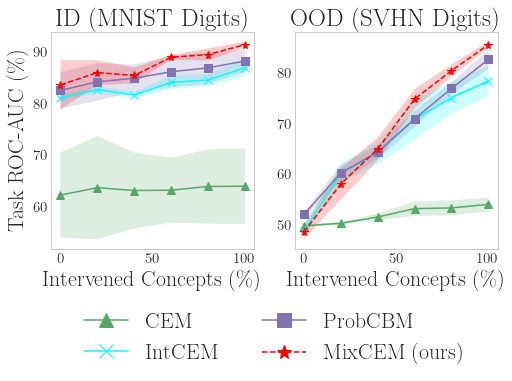

In [17]:
used_results_to_include = [
    x for x in results_to_include
    if "TravelingBirds" not in x['name']
]

used_baselines_to_include = [
    # "Joint CBM",
    # "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    # "Posthoc CBM",
    # "Posthoc Hybrid CBM",
    MAIN_METHOD,
    # "FixedOnlyGTCEM",
    # "Bayes MLP",
]
std_scale = 1
ood_suffix = 'OOD_SVHN_100_'
fig, axs = plt.subplots(len(used_results_to_include), 2, figsize=(8, 4*len(used_results_to_include)), squeeze=False)
for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        # ax = axs[row, col]
        ax = axs[col, row]
        for idx, label in enumerate(used_baselines_to_include):
            label = dataset_results.get('rename', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_auc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = rename_map.get(label, label)
            if ("Bayes" in label) and ("OOD" not in mode_name):
                continue
            print("For model", model_name, "we got ints", ints)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = dataset_results['n_concepts']
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1 + 1e-4, 1.0/(len(means) - 1)))
                )
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=8,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=8,
                )
            else:
                # Otherwise, plot all points
                print("xticks =", xticks)
                print("means =", means)
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=8,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - std_scale * stds,
                    means + std_scale * stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(-5, 105)
        if col == 0:
            if row == 0:
                # ax.set_ylabel("ID (MNIST Digits)\nTask ROC-AUC (\%)", fontsize=22)
                ax.set_title(r'ID (MNIST Digits)', fontsize=25)
            else:
                # ax.set_ylabel("OOD (SVHN Digits)\nTask ROC-AUC (\%)", fontsize=22)
                ax.set_title(r'OOD (SVHN Digits)', fontsize=25)

        # if row == (axs.shape[0] - 1):
        #     ax.set_xlabel("Intervened Concepts (\%)", fontsize=22)
        ax.set_xlabel("Intervened Concepts (\%)", fontsize=22)
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)
        ax.grid(False)
        if row == 0:
        #     ax.set_title(r'\texttt{' + dataset_results['name'] + '}', fontsize=25)
            ax.set_ylabel("Task ROC-AUC (\%)", fontsize=22)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=22,
    loc='upper center',
    # bbox_to_anchor=(0.5,-0.2),
    bbox_to_anchor=(-0.1,-0.2),
    ncol=2,
    markerscale=1.75,
)
plt.savefig(f"../figures/paper/rebuttal_mnist_add_svhn{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/paper/rebuttal_mnist_add_svhn{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.savefig(f"../figures/rebuttal_mnist_add_svhn{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/rebuttal_mnist_add_svhn{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

**************************************** Digit Addition ****************************************
	For DNN we selected: DNN (Baseline)
	For Joint CBM we selected: CBM_Sigmoid_cwl_1
	For Hybrid-CBM we selected: Hybrid-CBM_Sigmoid_extra_dims_50_cwl_1
	For Sigmoidal CEM we selected: Sigmoidal CEM (Baseline)
	For ProbCBM we selected: ProbCBM_cwl_class_hidden_dim_64_hidden_dim_32_n_samples_inference_50_max_concept_epochs_150_max_task_epochs_150
	For Posthoc CBM we selected: PCBM_reg_0.001_l1_0.99_penalty_1
	For Posthoc Hybrid CBM we selected: Posthoc Hybrid CBM (Baseline)
	For CEM we selected: CEM_emb_size_16_cwl_10
	For IntCEM we selected: IntCEM (Baseline)
	For MixCEM Final All Sample we selected: MixCEM_Final_t_1_r_10_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.5_emb_16_True_tip_0.25_itd_1_iw_0_cwl_10
xticks = [0, 25.0, 50.0, 75.0, 100.0]
means = [92.69168951 92.87523564 93.12750113 93.34465511 93.56856955]
Skipping IntCEM (Baseline) for Digit Addition as we could not find an

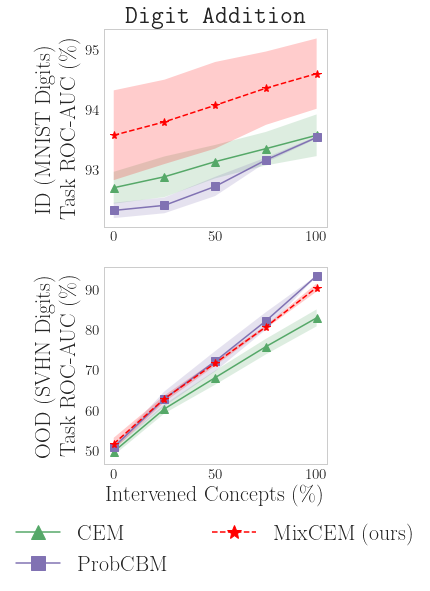

In [29]:
from texttable import Texttable
import latextable
from collections import defaultdict

results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/color_mnist_svhn_incomplete_rebuttal/',
        name='Digit Addition',
        n_concepts=40,
        n_groups=5,
    ),
]
select_metric = 'val_auc_y_random_group_level_True_use_prior_False_int_auc'
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))
    res['selected_models'] = joblib.load(os.path.join(res['path'], f'selected_models_{select_metric}.joblib'))

baselines_to_include = [
    "DNN",
    "Joint CBM",
    "Hybrid-CBM",
    "Sigmoidal CEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "CEM",
    "IntCEM",
    MAIN_METHOD,
]
for dataset_results in results_to_include:
    print("****" * 10, f"{dataset_results['name']}", "****" * 10)
    for label in baselines_to_include:
        real_label = dataset_results.get('rename', {}).get(label, label)
        used_select_metric = dataset_results.get(
            'select_metric',
            select_metric,
        )
        model_name = dataset_results['selected_models'].get(
            real_label + " (Baseline)",
            real_label + " (Baseline)",
        )
        print(f"\tFor {label} we selected:", model_name)

used_results_to_include = [
    x for x in results_to_include
    if "TravelingBirds" not in x['name']
]

used_baselines_to_include = [
    # "Joint CBM",
    # "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    # "Posthoc CBM",
    # "Posthoc Hybrid CBM",
    MAIN_METHOD,
    # "FixedOnlyGTCEM",
    # "Bayes MLP",
]
std_scale = 1
ood_suffix = 'OOD_SVHN_100_'
fig, axs = plt.subplots(2, len(used_results_to_include), figsize=(4*len(used_results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(used_baselines_to_include):
            label = dataset_results.get('rename', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_auc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = rename_map.get(label, label)
            if ("Bayes" in label) and ("OOD" not in mode_name):
                continue
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = dataset_results['n_concepts']
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1 + 1e-4, 1.0/(len(means) - 1)))
                )
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=8,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=8,
                )
            else:
                # Otherwise, plot all points
                print("xticks =", xticks)
                print("means =", means)
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=8,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - std_scale * stds,
                    means + std_scale * stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(-5, 105)
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID (MNIST Digits)\nTask ROC-AUC (\%)", fontsize=22)
            else:
                ax.set_ylabel("OOD (SVHN Digits)\nTask ROC-AUC (\%)", fontsize=22)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts (\%)", fontsize=22)
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)
        ax.grid(False)
        if row == 0:
            ax.set_title(r'\texttt{' + dataset_results['name'] + '}', fontsize=25)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=22,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.2),
    ncol=2,
    markerscale=1.75,
)
plt.savefig(f"../figures/paper/rebuttal_mnist_add_svhn_2{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/paper/rebuttal_mnist_add_svhn{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.savefig(f"../figures/rebuttal_mnist_add_svhn_2{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/rebuttal_mnist_add_svhn_2{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

# Inference Time Evaluation

In [30]:
result_dir = "/anfs/bigdisc/me466/mixcem_results/cub_complete/"
with open('/homes/me466/cem/experiments/configs/cub_mixcem_complete.yaml', "r") as f:
    experiment_config = yaml.load(f, Loader=yaml.FullLoader)

id_dataset_config =  {
    "dataset": "cub",
    "num_workers": 8,
    "batch_size": 64,

    # DATASET VARIABLES
    "root_dir": "/homes/me466/data/CUB200/",
    "sampling_percent": 0.25 if "cub_incomplete" in result_dir else 1,
    "sampling_groups": True,
    "test_subsampling": 1,
    "weight_loss": True,
}

In [35]:
import cem.utils.data as data_utils
# import cem.data.awa2_loader as data_module
import cem.data.CUB200.cub_loader as data_module
from cem.data.utils import transform_from_config


_, _, id_test_dl, imbalance, (n_concepts, n_tasks, concept_map) = \
    data_module.generate_data(
        config=id_dataset_config,
        seed=42,
        output_dataset_vars=True,
        root_dir=id_dataset_config.get('root_dir', None),
    )
# id_x_test, id_y_test, id_c_test = data_utils.daloader_to_memory(id_test_dl)

Global seed set to 42


In [36]:
import experiments.experiment_utils as experiment_utils
import joblib
split = 0
selected_models = joblib.load(
    os.path.join(result_dir, 'selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'),
)

In [59]:
# baselines_to_include = [
#     "Joint CBM",
#     "Hybrid-CBM",
#     "CEM",
#     # "Sigmoidal CEM",
#     "IntCEM",
#     "ProbCBM",
#     "Posthoc CBM",
#     "Posthoc Hybrid CBM",
#     "Entropy CMCMixCEM",
#     "Bayes MLP",
#     "Sequential CBM",
#     "Independent CBM",
# ]

models_to_include = [
    ("MixCEM", "MixCEM Final All (Baseline)"),
    ("DNN", "DNN (Baseline)"),
    ("CEM", "CEM (Baseline)"),
    ("Hybrid Posthoc CBM", "Posthoc Hybrid CBM (Baseline)"),
    ("Joint CBM", "Joint CBM (Baseline)"),
    ("Hybrid CBM", "Hybrid-CBM (Baseline)"),
    ("IntCEM", "IntCEM (Baseline)"),
    ("ProbCBM", "ProbCBM (Baseline)"),
    ("Posthoc CBM", "Posthoc CBM (Baseline)"),
]

In [60]:
from datetime import datetime
from cem.models.construction import load_trained_model
import pytorch_lightning as pl


inference_times = []
number_of_params = []

for real_model_name, used_model_name in models_to_include:
    root = selected_models[used_model_name]
    model_config = joblib.load(
        os.path.join(result_dir, root + "_experiment_config.joblib"),
    )

    task_class_weights = None
    model = load_trained_model(
        config=model_config,
        n_tasks=n_tasks,
        result_dir=result_dir,
        n_concepts=n_concepts,
        split=split,
        imbalance=imbalance,
        task_class_weights=task_class_weights,
        train_dl=None,
        logger=False,
        output_latent=False,
        output_interventions=False,
        enable_checkpointing=False,
    )
    trainer = pl.Trainer(
        gpus=1,
        logger=False,
    )

    print("Unintervened ID Bottlenecks for", real_model_name)
    now = datetime.now()
    id_test_batch_results = trainer.predict(
        model,
        id_test_dl,
    )
    then = datetime.now()
    diff = (then - now).total_seconds()
    secs_per_sample = diff/len(id_test_dl.dataset)
    params = sum(
        p.numel() for p in model.parameters()
    )
    print(real_model_name, "took", diff, f"seconds ({secs_per_sample}s per sample) using", params, "parameters")
    inference_times.append(secs_per_sample)
    number_of_params.append(params)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Unintervened ID Bottlenecks for MixCEM


Predicting: 0it [00:00, ?it/s]

MixCEM took 16.238278 seconds (0.0028026023472557822s per sample) using 16205919 parameters


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Unintervened ID Bottlenecks for DNN


Predicting: 0it [00:00, ?it/s]

DNN took 8.020344 seconds (0.0013842499137038315s per sample) using 11399168 parameters


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Unintervened ID Bottlenecks for CEM


Predicting: 0it [00:00, ?it/s]

CEM took 8.33609 seconds (0.0014387452537107353s per sample) using 15635729 parameters


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Unintervened ID Bottlenecks for Hybrid Posthoc CBM


Predicting: 0it [00:00, ?it/s]

Hybrid Posthoc CBM took 2.477404 seconds (0.0004275809458060062s per sample) using 11291824 parameters


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Unintervened ID Bottlenecks for Joint CBM


Predicting: 0it [00:00, ?it/s]

Joint CBM took 8.050648 seconds (0.0013894801518812565s per sample) using 11256568 parameters


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Unintervened ID Bottlenecks for Hybrid CBM


Predicting: 0it [00:00, ?it/s]

In [58]:
mixcem_time = inference_times[0]
mixcem_params = number_of_params[0]
for (real_model_name, used_model_name), secs_per_sample, params in zip(
    models_to_include,
    inference_times,
    number_of_params,
):
    if secs_per_sample > mixcem_time:
        diff_time_mixcem = f"(+{100*(secs_per_sample - mixcem_time)/secs_per_sample:.2f}%)"
    else:
        diff_time_mixcem = f"(-{100*(mixcem_time - secs_per_sample)/secs_per_sample:.2f}%)"
    if params > mixcem_params:
        diff_params_mixcem = f"(+{100*(params - mixcem_params)/params:.2f}%)"
    else:
        diff_params_mixcem = f"(-{100*(mixcem_params - params)/params:.2f}%)"
    print(real_model_name, "took", f"{secs_per_sample}s per sample ({diff_time_mixcem}) using", params, f"parameters {diff_params_mixcem}")


MixCEM took 0.0014970132896099414s per sample ((-0.00%)) using 16205919 parameters (-0.00%)
CEM took 0.0014366972730410767s per sample ((-4.20%)) using 15635729 parameters (-3.65%)
Hybrid Posthoc CBM took 0.001432631342768381s per sample ((-4.49%)) using 11291824 parameters (-43.52%)
Joint CBM took 0.0013857968588194684s per sample ((-8.03%)) using 11256568 parameters (-43.97%)
Hybrid CBM took 0.0013941341042457713s per sample ((-7.38%)) using 11292218 parameters (-43.51%)
IntCEM took 0.0014309351052813257s per sample ((-4.62%)) using 15918558 parameters (-1.81%)
ProbCBM took 0.005686973938557128s per sample ((+73.68%)) using 81470660 parameters (+80.11%)
Posthoc CBM took 0.0014263016914049017s per sample ((-4.96%)) using 11269224 parameters (-43.81%)
